In [1]:
%pip install --user pandas scipy numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import time
import numpy as np
from scipy.stats import chisquare
import collections
import math
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import gamma
from scipy.stats import chi2
from scipy.stats import kstest
from scipy.stats import rankdata
import random
import glob
import bz2
import os

#### Data prepartion, and excluding extremes (cut tail)

In [3]:
# Define a function to extract the leading digit from a string
def get_leading_digit(s):
    # Strip leading zeros
    s = s.lstrip('0')
    
    # If the first character is a decimal point, find the first non-zero digit after it
    if s and s[0] == '.':
        s = s[1:].lstrip('0')
    
    # Return the first non-zero digit, or 0 if no such digit is found
    return int(s[0]) if s else 0

# Define a function to convert a string to a float
def convert_to_number(s):
    try:
        return float(s)
    except ValueError:
        return None

# Initialize a list for the numbers
numbers = []

# Retrieve all .trans files, change if needed
filenames = glob.glob('/mnt/data/exomol/exomol3_data/TiO/49Ti-16O/Toto/*.trans.bz2')
filenames = sorted(filenames)

# ## For sample input
# # get current repository
# current_directory = os.getcwd()
# filenames = glob.glob(os.path.join(current_directory, '*.trans.bz2'))

# Iterate over each file and extract numbers
for filename in filenames:
    # Open the file
    with bz2.open(filename, 'r') as file:

        # loop over the lines in the file
        for line in file:
            # Decode the line to a string
            line = line.decode('utf-8')    
            
            # Split the line on spaces (or appropriate delimiter)
            data = line.strip().split()

            # Convert the third column to a number and add it to the list
            number = convert_to_number(data[2])
            if number is not None:
                numbers.append(number)


In [4]:
# Compute a histogram of the logarithm of the numbers
hist, bins = np.histogram(np.log10(numbers), bins=np.logspace(np.log10(min(numbers)), np.log10(max(numbers)), 20))

# Display the histogram data
print(hist, bins)

# Filter bins that have a frequency above threshold
threshold = 1000
relevant_bins = [bins[i] for i, freq in enumerate(hist) if freq > threshold]

# Extract numbers that fall within the relevant bins and their leading digits
filtered_numbers = []
filtered_leading_digits = collections.Counter()

for num in numbers:
    for i in range(len(relevant_bins) - 1):
        if relevant_bins[i] <= num <= relevant_bins[i + 1]:
            filtered_numbers.append(num)
            filtered_leading_digits.update([get_leading_digit(str(num))])

# Count the frequency of each leading digit
filtered_observed_frequencies = dict(sorted(filtered_leading_digits.items()))

# Calculate the total count of leading digits
total_count = sum(filtered_leading_digits.values())

# Display the observed frequencies
print(filtered_observed_frequencies)

[       0        0        0        0        0        0        0        0
        0        0        0        0        0        0        0        0
   445544 13923006        0] [2.28190000e-71 2.91239590e-67 3.71709973e-63 4.74414567e-59
 6.05496752e-55 7.72797342e-51 9.86323594e-47 1.25884780e-42
 1.60667127e-38 2.05059941e-34 2.61718626e-30 3.34032277e-26
 4.26326409e-22 5.44121690e-18 6.94464165e-14 8.86346722e-10
 1.13124701e-05 1.44381400e-01 1.84274419e+03 2.35190000e+07]
{1: 3966644, 2: 2147821, 3: 1526857, 4: 1187498, 5: 965867, 6: 812270, 7: 708419, 8: 631269, 9: 565686}


In [5]:
observed_frequencies = filtered_observed_frequencies

#### Plot visulisation for transformed dataset on a log scale

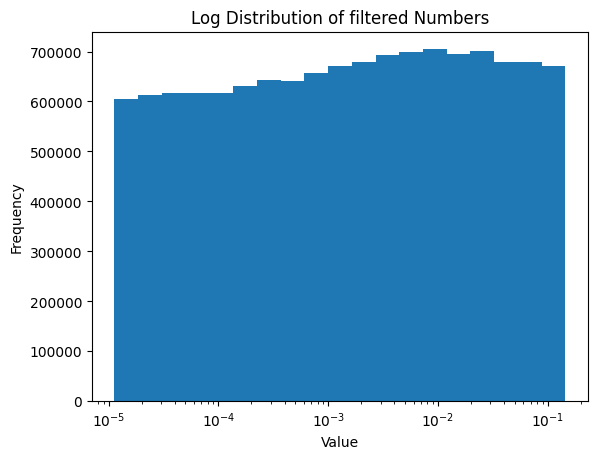

In [6]:
# To visualise the distribution of data on a logarithmic scale,
plt.hist(filtered_numbers, bins=np.logspace(np.log10(min(filtered_numbers)), np.log10(max(filtered_numbers)), 20))
plt.xscale('log')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Log Distribution of filtered Numbers')
plt.show()

#### Chi-square test

In [7]:
# Calculate the expected frequency for each leading digit under the assumption of Benford's Law
expected_frequencies_ben = {i: total_count * math.log10(1 + 1/i) for i in range(1, 10)}

# As the function shows above, calculate chi_squate statistic
def chi_square_statistic(observed, expected):
    return sum([(o - e)**2 / e for o, e in zip(observed, expected)])

# Use the custom chi-square statistic function
chi2_stat_ben = chi_square_statistic(list(observed_frequencies.values()), list(expected_frequencies_ben.values()))

# Print chi-square values
print("Chi-square statistic for Benford's Law:", chi2_stat_ben)


# Chi-square PDF
def chi2_pdf(x, df):
    return (1 / (2 ** (df / 2) * gamma(df / 2))) * x ** (df / 2 - 1) * np.exp(-x / 2)

# Compute the p-value using numerical integration
def chi2_p_value_from_scratch(chi2_stat, df):
    # Integrate from chi2_stat to infinity
    return quad(chi2_pdf, chi2_stat, np.inf, args=(df))[0]

# Calculate p-values
df = 9 - 1
p_value_ben_scratch = chi2_p_value_from_scratch(chi2_stat_ben, df)
print("P-value from scratch for Benford's Law:", p_value_ben_scratch)

# Calculate critical value for the comparison of Chi-square statistic
p_threshold = 0.001
critical_value = chi2.ppf(1 - p_threshold, df)
print("Critical_value in this task: ",critical_value)

Chi-square statistic for Benford's Law: 15393.76632225458
P-value from scratch for Benford's Law: 0.0
Critical_value in this task:  26.12448155837614


#### Plot bar chats comparing the first digits of the observed (dataset) with the expected (Benford's Law), with Chi-square and MAD results

Chi-square statistic for Benford's Law expected frequency: 15393.76632225458
P-value for Benford's Law expected frequency: 0.0
MAD for Benford's Law : 0.0035530648094925527


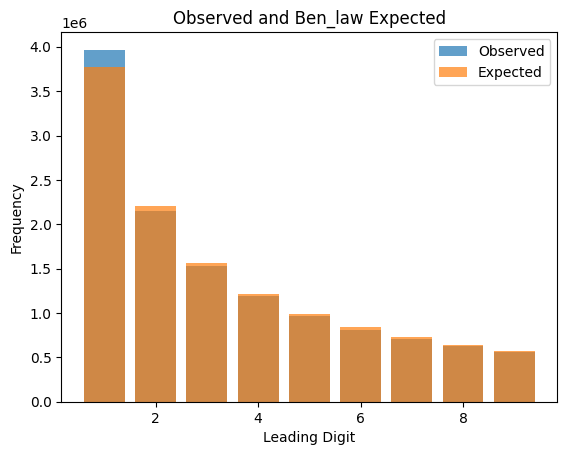

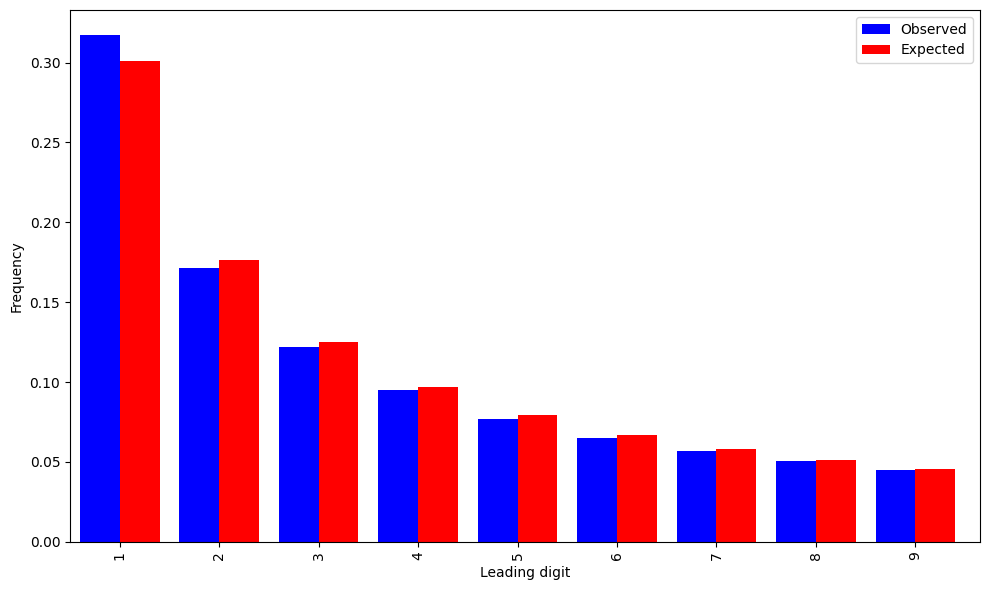

In [9]:
# Perform a chi-square test by using function in library and compared with the calculation we built from the ground
chi2_ben, p_ben = chisquare(list(observed_frequencies.values()), list(expected_frequencies_ben.values()))

# Print the results for Benford's Law
print(f"Chi-square statistic for Benford's Law expected frequency: {chi2_ben}")
print(f"P-value for Benford's Law expected frequency: {p_ben}")

# Convert the frequencies to ratios
observed_ratios = {k: v / total_count for k, v in observed_frequencies.items()}

# Calculate expected frequencies according to Benford's law
expected_frequencies = {i: math.log10(1 + 1 / i) for i in range(1, 10)}

# Calculate the expected frequency for each leading digit under the assumption of Benford's Law
probability_distribution_ben = expected_frequencies

# Calculate the frequency for each leading digit under the observed dataset
probability_distribution_obv = observed_ratios

# Compute the MAD
MAD = sum(abs(probability_distribution_obv[d] - probability_distribution_ben[d]) for d in range(1, 10)) / 9
print(f"MAD for Benford's Law : {MAD}")

# Create a bar plot for Benford's Law
plt.title('Observed and Ben_law Expected')
plt.bar(range(1, 10), [observed_frequencies[i] for i in range(1, 10)], alpha=0.7, label='Observed')
plt.bar(range(1, 10), [expected_frequencies_ben[i] for i in range(1, 10)], alpha=0.7, label='Expected')
plt.xlabel('Leading Digit')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Create a dataframe from the observed and expected ratios
df = pd.DataFrame({'observed': observed_ratios, 'expected': expected_frequencies})

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
df['observed'].plot(kind='bar', color='blue', ax=ax, width=0.4, position=1, label='Observed')
df['expected'].plot(kind='bar', color='red', ax=ax, width=0.4, position=0, label='Expected')
ax.set_xlabel('Leading digit')
ax.set_ylabel('Frequency')
ax.set_xlim(left=-0.5)  
plt.tight_layout() 
plt.legend()
plt.show()
